# Homework 2 - Part 2: GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from scipy import signal

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)

# define the transform to tensor
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))    # image scaled between -1 and 1
])

train_dataset.transform = data_transform

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Define Models

In [ ]:
# discriminator class
class DiscriminatorOld(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 28*28)

        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.01),  
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64),
    
            nn.Conv2d(64, 128, 4, stride=1, padding=0),
            nn.LeakyReLU(0.01),
        )
        self.flat = nn.Flatten(start_dim=1)
        self.lin = nn.Sequential(
            nn.Linear(4 * 4 * 128, 1),  #128,  1024,
            nn.Sigmoid()
        )

    def forward(self, x, labels, feature_matching=False):
      c = self.label_emb(labels)
      c = c.view(-1,1,28,28)
      x = torch.cat((x,c), dim=1)
      x = self.conv(x)
      feature = self.flat(x)
      x = self.lin(feature)
      if feature_matching:
        return feature, x
      return x

torch.Size([256, 1, 28, 28])
torch.Size([256, 1])


In [ ]:
# generator class

class GeneratorOld(nn.Module):
    def __init__(self, z_dim): #, img_dim
        super().__init__()

        self.label_emb = nn.Embedding(10, 20)

        self.lin = nn.Sequential(
            nn.Linear(z_dim + 20, 7*7*128),  
            nn.LeakyReLU(0.01),    
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1, output_padding=0),
            nn.LeakyReLU(0.01),
            nn.Tanh()
        )

    def forward(self, x, labels):
      c = self.label_emb(labels)
      x = torch.cat((x,c), dim=1)
      x = self.lin(x)
      x = x.view((-1,128,7,7))  # reshape to (batch_size, channels, 7, 7)
      x = self.conv(x)
      return x

torch.Size([256, 100])
torch.Size([256, 1, 28, 28])


## Useful Fuctions

In [ ]:
# weight normal initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Hyperparameters, optimizer, loss function and initializations

In [ ]:
# Hyperparameters, optimizer, loss function, initialize networks

device = "cuda" if torch.cuda.is_available() else "cpu"
lr_gen = 3e-4 
lr_disc = 3e-4 
z_dim = 40  # + 20 for label encoding 
num_epochs = 20

disc = DiscriminatorOld().to(device)
gen = GeneratorOld(z_dim).to(device)

# initialize weights
gen.apply(weights_init_normal)
disc.apply(weights_init_normal)

optimizer_disc = optim.Adam(disc.parameters(), lr=lr_disc, betas=(0.5,0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5,0.999))

loss_fun = nn.BCELoss()
feature_match_fun = nn.MSELoss()

noise_intensity = 3
print('Network initialized')

Network initialized


## Training

# EPOCH 0


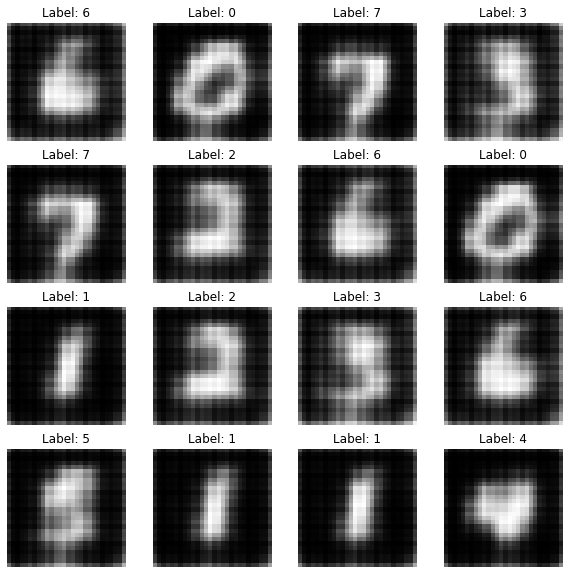

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average generator loss: nan
Average feature matching generator loss: 0.5506681203842163
Average discriminator loss: 0.1506519466638565
Average fake accuracy: 0.9413231382978723
Average real accuracy: 0.9483599290780141
# EPOCH 1


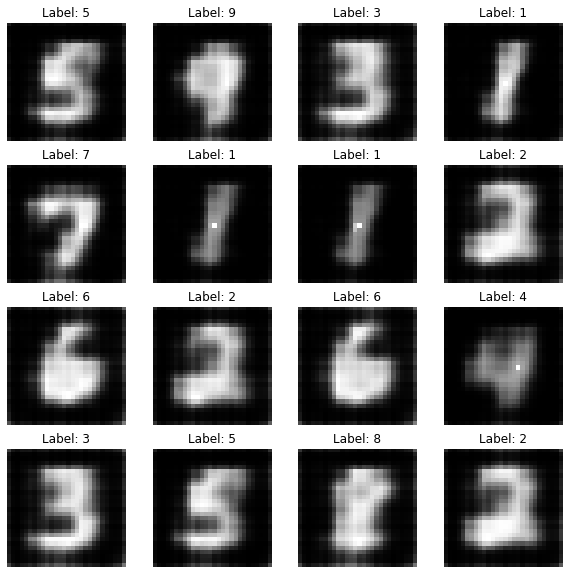

Average generator loss: nan
Average feature matching generator loss: 0.24176061153411865
Average discriminator loss: 0.1414811611175537
Average fake accuracy: 0.9537898936170213
Average real accuracy: 0.9524434840425532
# EPOCH 2


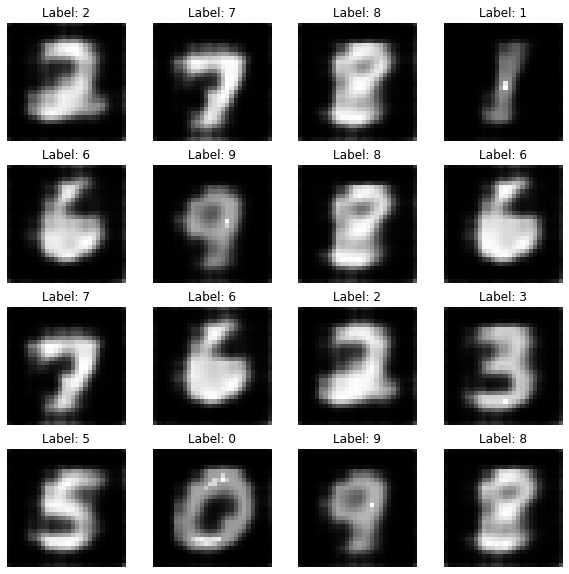

Average generator loss: nan
Average feature matching generator loss: 0.22513748705387115
Average discriminator loss: 0.1458389014005661
Average fake accuracy: 0.947091090425532
Average real accuracy: 0.9468251329787234
# EPOCH 3


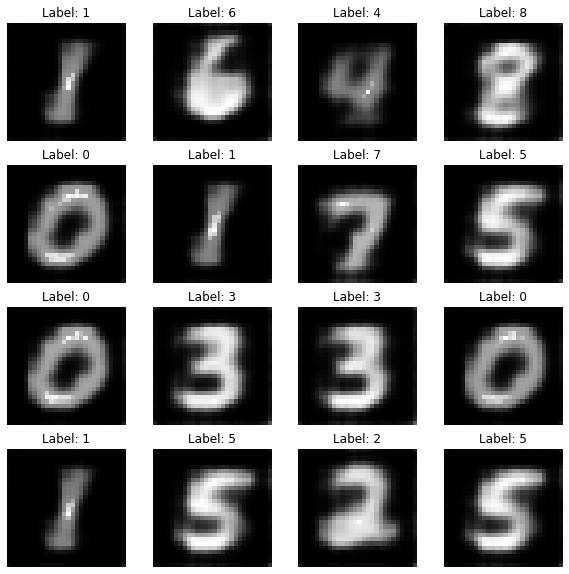

Average generator loss: nan
Average feature matching generator loss: 0.2205248922109604
Average discriminator loss: 0.0884949117898941
Average fake accuracy: 0.9715093085106383
Average real accuracy: 0.9708222517730497
# EPOCH 4


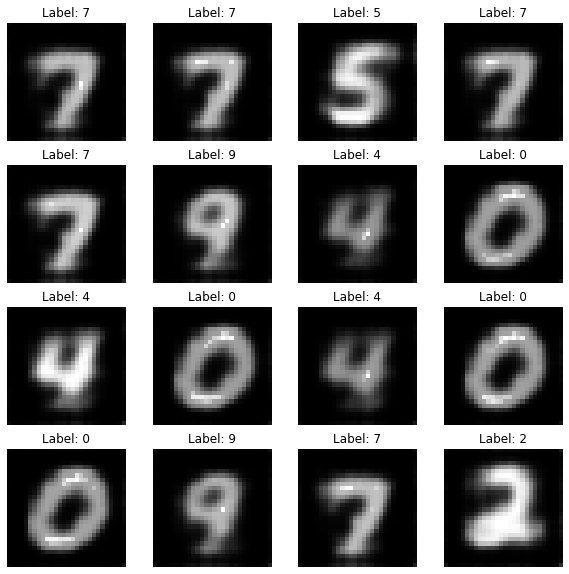

Average generator loss: nan
Average feature matching generator loss: 0.2183859646320343
Average discriminator loss: 0.09420549124479294
Average fake accuracy: 0.9702626329787234
Average real accuracy: 0.9699301861702128
# EPOCH 5


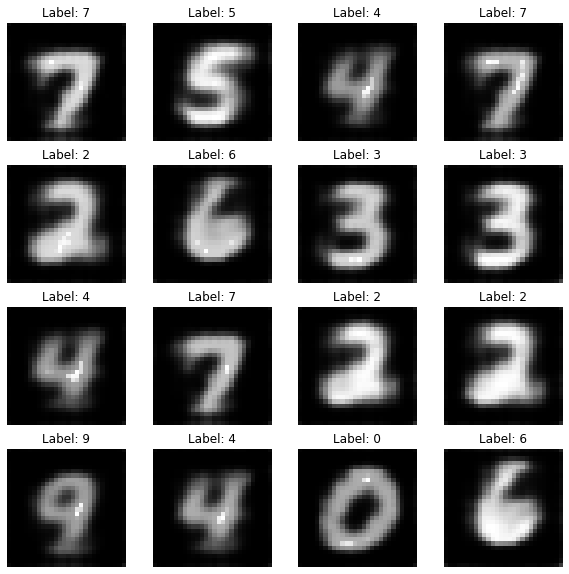

Average generator loss: nan
Average feature matching generator loss: 0.21715891361236572
Average discriminator loss: 0.05552487075328827
Average fake accuracy: 0.986968085106383
Average real accuracy: 0.9865248226950354
# EPOCH 6


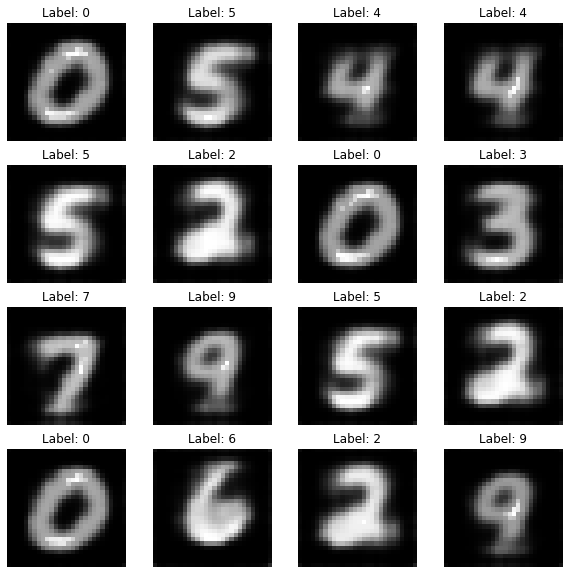

Average generator loss: nan
Average feature matching generator loss: 0.21651363372802734
Average discriminator loss: 0.0518130287528038
Average fake accuracy: 0.9864915780141843
Average real accuracy: 0.9868406471631205
# EPOCH 7


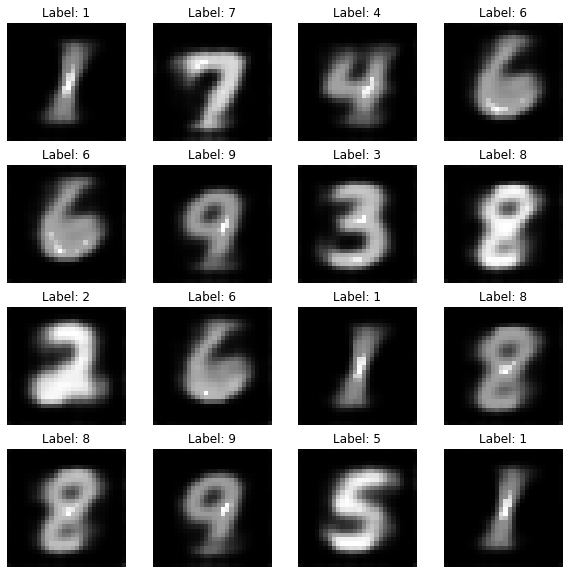

Average generator loss: nan
Average feature matching generator loss: 0.21612274646759033
Average discriminator loss: 0.025367310270667076
Average fake accuracy: 0.9938996010638298
Average real accuracy: 0.9933011968085106
# EPOCH 8


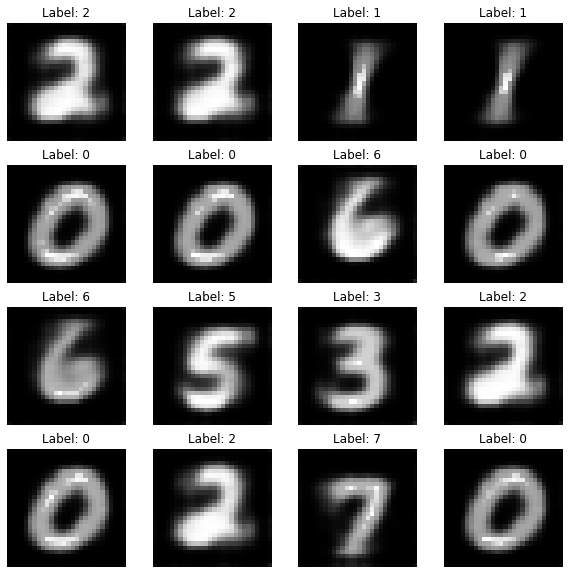

Average generator loss: nan
Average feature matching generator loss: 0.21577653288841248
Average discriminator loss: 0.01344416756182909
Average fake accuracy: 0.9975398936170212
Average real accuracy: 0.997406914893617
# EPOCH 9


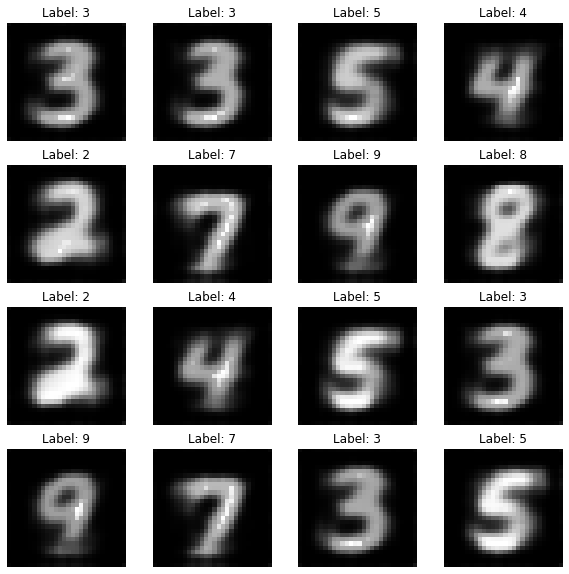

Average generator loss: nan
Average feature matching generator loss: 0.21547697484493256
Average discriminator loss: 0.9396105408668518
Average fake accuracy: 0.9685837765957447
Average real accuracy: 0.9857047872340425
# EPOCH 10


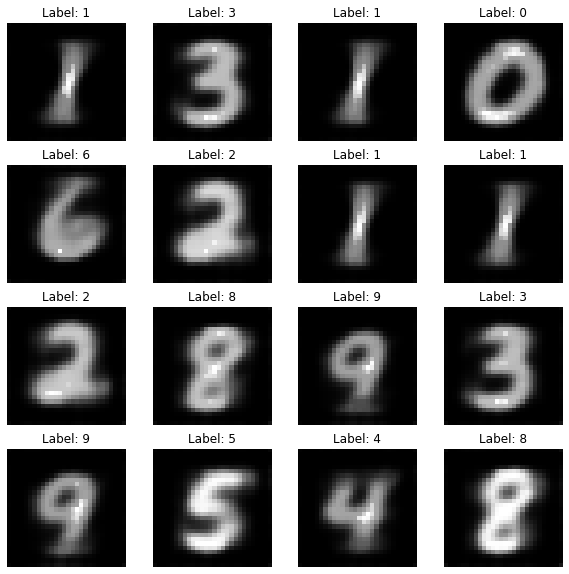

Average generator loss: nan
Average feature matching generator loss: 0.21522171795368195
Average discriminator loss: 0.009041184559464455
Average fake accuracy: 0.9990857712765957
Average real accuracy: 0.9990359042553192
# EPOCH 11


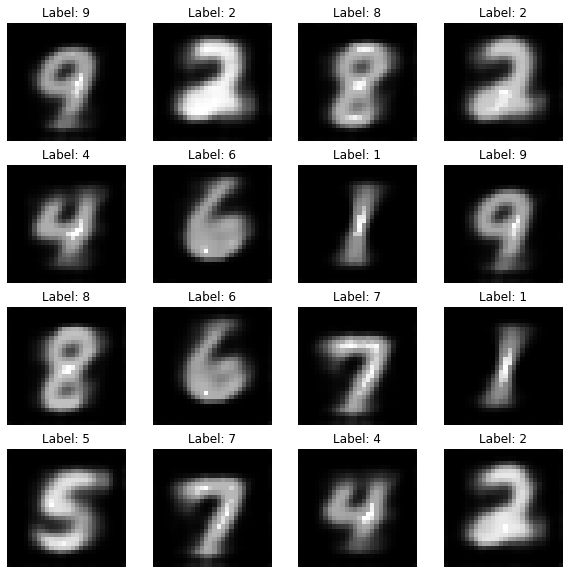

Average generator loss: nan
Average feature matching generator loss: 0.2150886058807373
Average discriminator loss: 0.40828365087509155
Average fake accuracy: 0.9800531914893617
Average real accuracy: 0.9875
# EPOCH 12


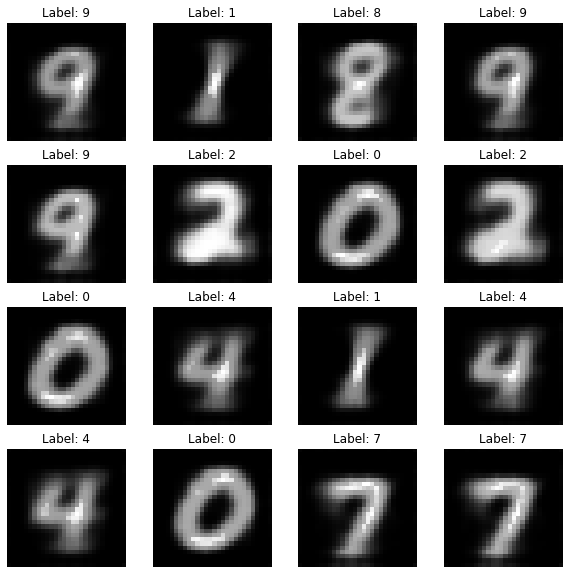

Average generator loss: nan
Average feature matching generator loss: 0.2150191217660904
Average discriminator loss: 0.02201874554157257
Average fake accuracy: 0.9949135638297872
Average real accuracy: 0.9945146276595744
# EPOCH 13


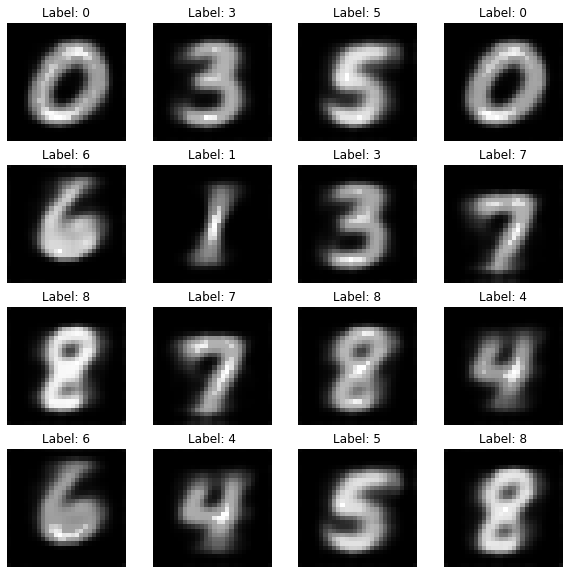

Average generator loss: nan
Average feature matching generator loss: 0.21493922173976898
Average discriminator loss: 0.005173817276954651
Average fake accuracy: 0.999783909574468
Average real accuracy: 0.999750664893617
# EPOCH 14


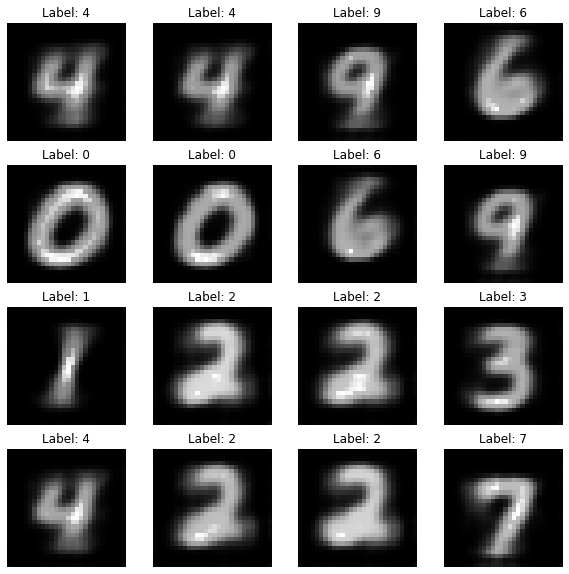

Average generator loss: nan
Average feature matching generator loss: 0.21486569941043854
Average discriminator loss: 0.003396824933588505
Average fake accuracy: 0.9999501329787234
Average real accuracy: 0.9997672872340425
# EPOCH 15


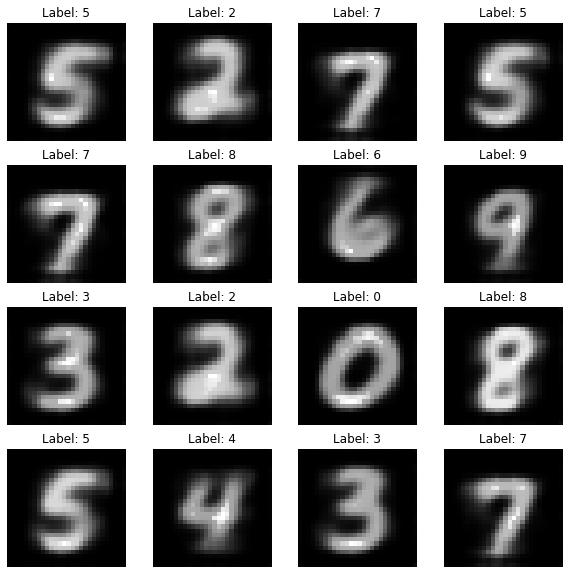

Average generator loss: nan
Average feature matching generator loss: 0.21480226516723633
Average discriminator loss: 0.352487176656723
Average fake accuracy: 0.9843583776595745
Average real accuracy: 0.9903257978723404
# EPOCH 16


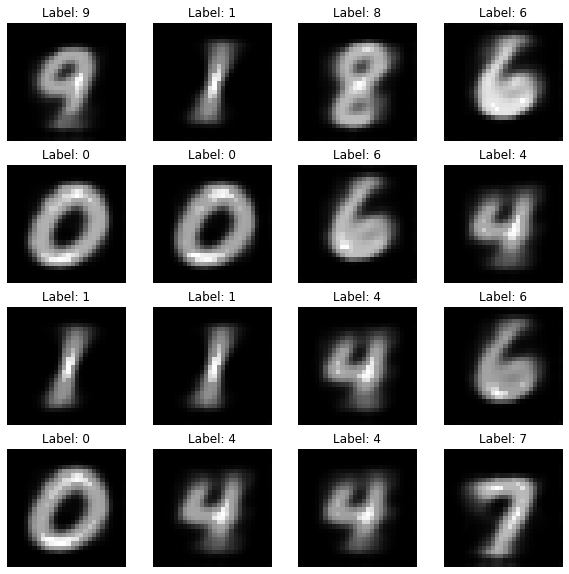

Average generator loss: nan
Average feature matching generator loss: 0.21471966803073883
Average discriminator loss: 0.004594423342496157
Average fake accuracy: 0.9998337765957447
Average real accuracy: 0.999783909574468
# EPOCH 17


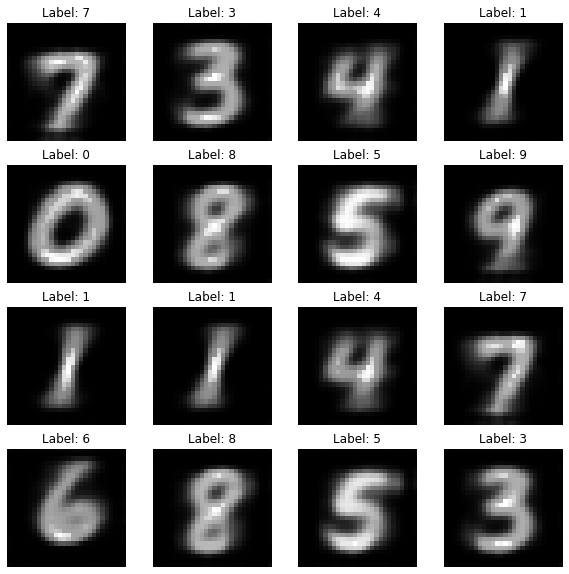

Average generator loss: nan
Average feature matching generator loss: 0.21467390656471252
Average discriminator loss: 0.0027178064920008183
Average fake accuracy: 0.9999501329787234
Average real accuracy: 0.9998393173758865
# EPOCH 18


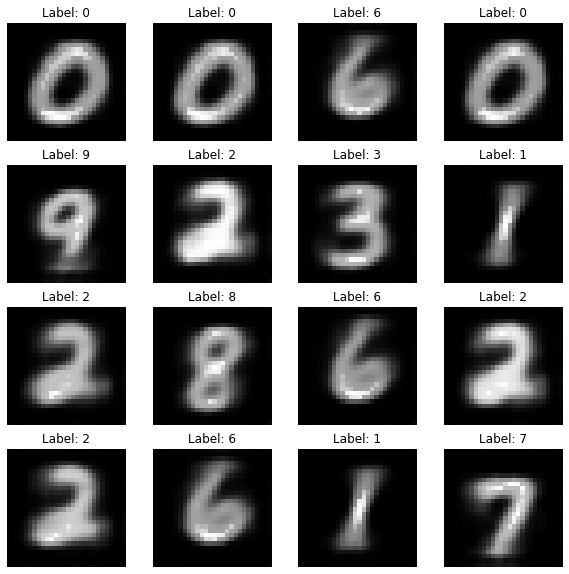

Average generator loss: nan
Average feature matching generator loss: 0.2146150916814804
Average discriminator loss: 0.0021128386724740267
Average fake accuracy: 0.9999667553191489
Average real accuracy: 0.9999335106382978
# EPOCH 19


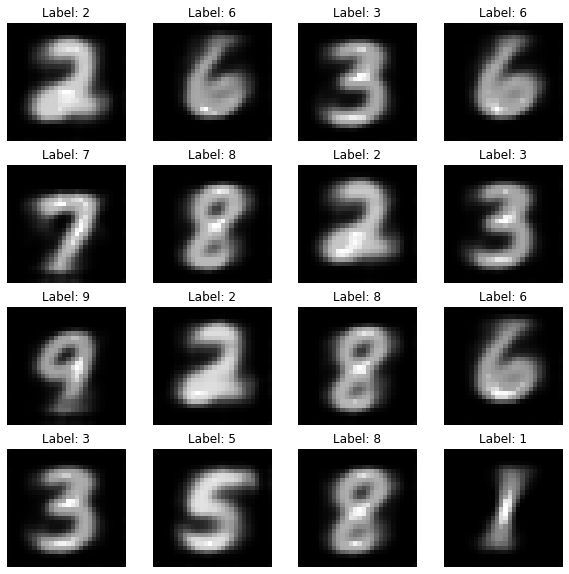

Average generator loss: nan
Average feature matching generator loss: 0.2145398110151291
Average discriminator loss: 0.0014580576680600643
Average fake accuracy: 0.9999501329787234
Average real accuracy: 0.9999002659574469


In [ ]:
# training

disc_loss_log = []
gen_loss_log = []
gen_fm_loss_log = []


disc_loss_log_temp = []
gen_loss_log_temp = []
gen_fm_loss_log_temp = []

acc_fake_log = []
acc_real_log = []

acc_fake_temp = []
acc_real_temp = []

# exponentially decreasing noise
tau2 = -(300-3) / np.log(0.1)
noise_std = signal.exponential(num_epochs, 0, tau2, False)*noise_intensity    

for epoch in range(num_epochs):
    print(f'# EPOCH {epoch}')

    for batch_idx, (real, label) in enumerate(train_dataloader):
        real = real.to(device)
        label = label.to(device)
        batch_size = real.shape[0]

        ######## Train Discriminator: max log(D(x)) + log(1 - D(G(z)))  ############
        disc.zero_grad()           

        disc.train()
        gen.eval()                 

        # input noise + labels fed to generator
        z = torch.empty((batch_size, z_dim)).normal_(mean=0,std=0.1).to(device)
        fake = gen(z, label) 

        # add noise to images before feeding them to disc
        real_noisy = real + torch.empty((real.shape)).normal_(mean=0, std=noise_std[epoch]).to(device)
        fake_noisy = fake + torch.empty((fake.shape)).normal_(mean=0, std=noise_std[epoch]).to(device)

        # feed real images to disc
        disc_real = disc(real_noisy, label).view(-1)

        #compute discriminator loss for real images
        loss_disc_real = loss_fun(disc_real, torch.ones_like(disc_real))
        
        # save fake images prediction for accuracy  
        pred_real = disc_real.detach().cpu().numpy()
        pred_real = [int(round(x)) for x in pred_real]    # rounds to 1 if real, 0 if fake
        acc_real = sum(pred_real)/len(pred_real)   # number of 1 over the total size
        acc_real_temp.append(acc_real)

        # compute discriminator loss over fake images from generator
        disc_fake = disc(fake_noisy, label).view(-1)
        
        # compute the discriminator loss over fake images
        loss_disc_fake = loss_fun(disc_fake, torch.zeros_like(disc_fake))

        # compute fake accuracy
        pred_fake = disc_fake.detach().cpu().numpy()
        pred_fake = [int(round(x)) for x in pred_fake]
        acc_fake = (len(pred_fake)-sum(pred_fake))/len(pred_fake)   # number of 0 over the total size
        acc_fake_temp.append(acc_fake)
        
        # compute the mean disc loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # compute gradient and step forward optimizer discriminator
        loss_disc.backward(retain_graph=True)
        optimizer_disc.step()

        # append discriminator loss
        disc_loss_log_temp.append(loss_disc.cpu().detach().numpy())


        ####### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))  #############


        gen.zero_grad()
        gen.train()          

        disc.eval()

        # compute feature matching loss 
        feature_fake, output = disc(fake_noisy, label, True)
        feature_real,_ = disc(real_noisy, label, True)

        feature_fake = torch.mean(feature_fake, 0)
        feature_real = torch.mean(feature_real, 0)

        # compute generator loss from discriminator predictions
        # loss_gen = loss_fun(output, torch.ones_like(output))   # normal loss (no feature matching. reversed labels, in this case the fake images are 1)
        loss_feature_match = feature_match_fun(feature_fake, feature_real)

        loss_feature_match = feature_match_fun(fake, real)                                                         
    
        # compute gradient and step optimizer generator
        loss_feature_match.backward()                                                                              
        optimizer_gen.step()

        # append generator loss 
        gen_fm_loss_log_temp.append(loss_feature_match.cpu().detach().numpy())                                     

    # print sample of generated image
    gen.eval()
    with torch.no_grad(): 
      noise_gen = torch.empty((batch_size, z_dim)).normal_(mean=0,std=0.5).to(device)
      label_sample = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
      generated_images = gen(noise_gen, label_sample)

      generated_images = generated_images.cpu().detach().numpy().squeeze()
      fig = plt.figure(figsize=(10,10))
      for i in range(4 * 4):
          ax = plt.subplot(4, 4, 1 + i)
          ax.set_title(f'Label: {label_sample[i]}')
          ax.axis('off')
          ax.imshow(generated_images[i, :, :], cmap='gist_gray')
          
      plt.show()


    # save average loss over the epoch
    disc_loss_log.append(np.mean(disc_loss_log_temp))
    gen_loss_log.append(np.mean(gen_loss_log_temp))
    gen_fm_loss_log.append(np.mean(gen_fm_loss_log_temp))

    # save average accuracy over the epoch
    acc_fake_log.append(np.mean(acc_fake_temp))
    acc_real_log.append(np.mean(acc_real_temp))

    # print average loss of gen and disc
    print(f"Average generator loss: {np.mean(gen_loss_log_temp)}")
    print(f"Average feature matching generator loss: {np.mean(gen_fm_loss_log_temp)}")
    print(f"Average discriminator loss: {np.mean(disc_loss_log_temp)}")

    # print average real and fake accuract
    print(f"Average fake accuracy: {np.mean(acc_fake_temp)}")
    print(f"Average real accuracy: {np.mean(acc_real_temp)}")

    # empty temporary variables
    gen_loss_log_temp = []
    gen_fm_loss_log_temp = []
    disc_loss_log_temp = []
    acc_fake_temp = []
    acc_real_temp = []


Generator error: nan
Generator feature matching error: 0.21467013657093048
Discriminator error: 0.07267405092716217


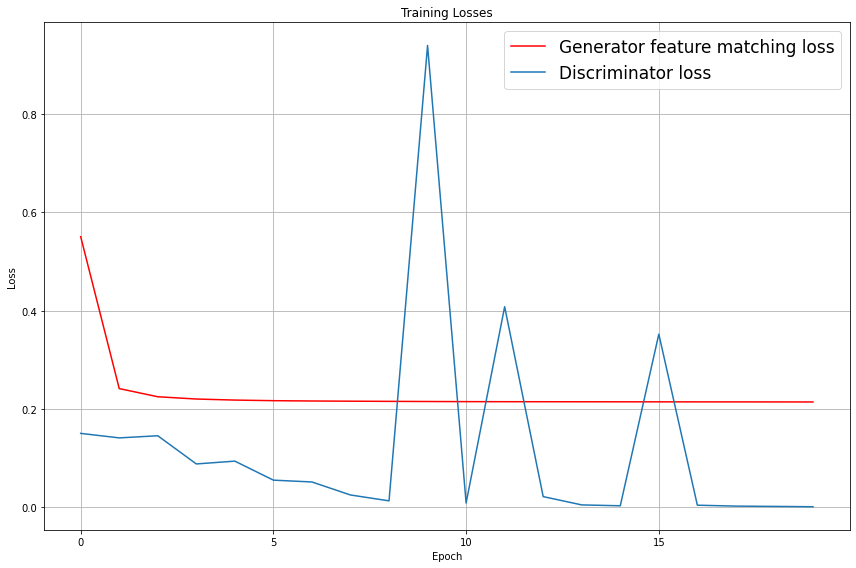

In [ ]:
# plot loss

print('Generator error: {}'.format(np.mean(gen_loss_log[-5:])))
print('Generator feature matching error: {}'.format(np.mean(gen_fm_loss_log[-5:])))

print('Discriminator error: {}'.format(np.mean(disc_loss_log[-5:])))

#Plot
plt.figure(figsize=(12,8))
# plt.plot(gen_loss_log, label='Generator loss')
plt.plot(gen_fm_loss_log, label='Generator feature matching loss', color='r')
plt.plot(disc_loss_log, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.xticks(np.arange(0, num_epochs, 5))
plt.grid()
plt.legend(prop={'size':17})

plt.tight_layout()

plt.savefig('training_plot_final')

plt.show()

Final fake accuracy: 0.9999584441489362
Final real accuracy: 0.9999168882978724


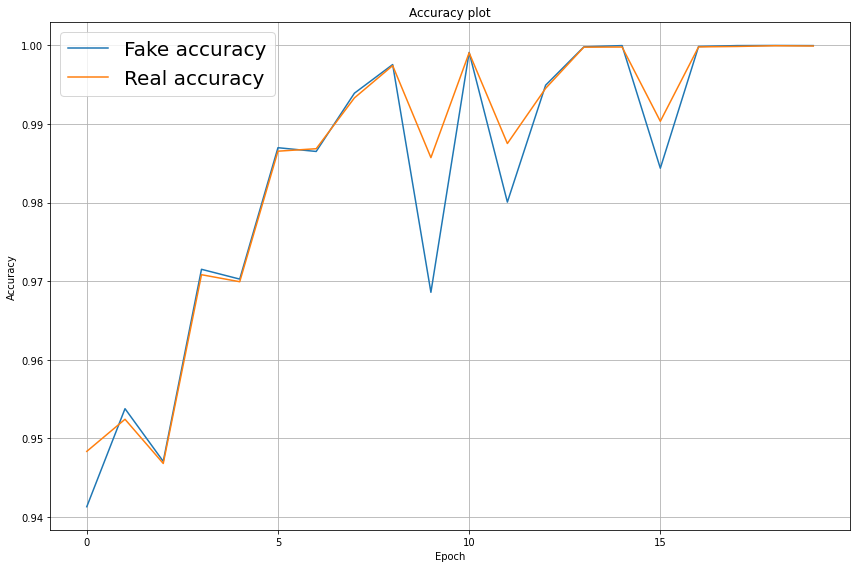

In [ ]:
# plot accuracy over training

print('Final fake accuracy: {}'.format(np.mean(acc_fake_log[-2:])))
print('Final real accuracy: {}'.format(np.mean(acc_real_log[-2:])))

#Plot
plt.figure(figsize=(12,8))
plt.plot(acc_fake_log, label='Fake accuracy')
plt.plot(acc_real_log, label='Real accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.xticks(np.arange(0, num_epochs, 5))

plt.grid()
plt.legend(prop={'size':20})

plt.tight_layout()

plt.savefig('accuracy_plot_final')

plt.show()

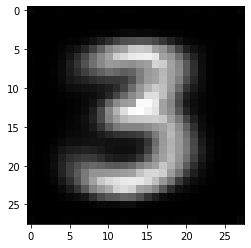

In [ ]:
# show generated images
plt.imshow(fake.cpu().detach().numpy()[2,:,:,:].squeeze(), cmap='gist_gray')

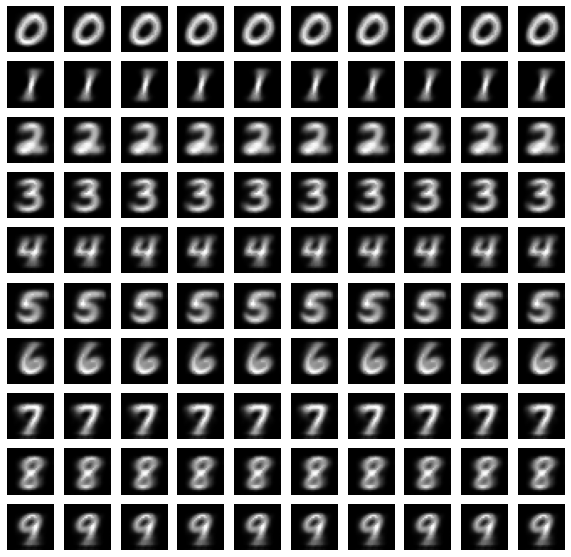

In [ ]:
# generate customized images

fake_label = torch.LongTensor([i for i in range(10) for j in range(10)]).to(device)
z = torch.empty((100, z_dim)).normal_(mean=0,std=0.02).to(device)

gen.eval()
with torch.no_grad():
  gen_images = gen(z,fake_label)

fig = plt.figure(figsize=(10,10))
for i in range(10 * 10):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(gen_images.cpu().squeeze()[i, :, :], cmap='gist_gray')
  

plt.savefig('generated_images_12jan_3e-4_40_20ep_3noise_fulldataset_drop')
